#Mega Case Study - Making a hybrid Deep Learning Model

Creating a Hybrid DL Model

Working with SOM(to detect frauds) and ANN (to predict probability of cheating)

#Part 1 - SOM (Unsupervised DL)

##Install MiniSom Package

In [54]:
!pip install MiniSom

## Importing the libraries


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing the dataset

In [56]:
dataset = pd.read_csv("Credit_Card_Applications.csv")

# Fraud is generally defined as sth far from the general rules. The frauds are
# the outlying neurons in the 2D SOM simply because  the outlier neurons are
# far from the majority of neurons in the neighbourhood

# To detect the outlying neurons, we need the MID (mean interneuron distance)
# mean of the Euclidean distance b/n a neuron and the neurons in its env't

# dataset[Class] = applicant approved or not

X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

## Feature Scaling


In [57]:
# conc for DL
# for SOM, use Normalisation instead of Standardisation
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)

##Training the SOM


In [58]:
#Minisom(self, x, y, input_len, sigma, learning_rate...)
# x,y = grid of our SOM(10x10)
#length of our input is 15 (check X size)
#sigma = radius of different neighbourhoods in grid
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len = 15, sigma = 1, learning_rate = 0.5)
som.random_weights_init(X)#randomise the weights
som.train_random(data=X, num_iteration=100)

##Visualizing the results


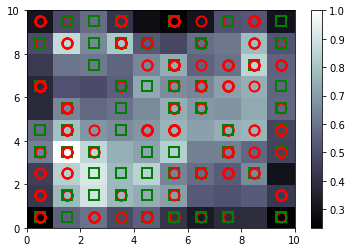

In [59]:
from pylab import bone, pcolor, colorbar, plot, show
bone() #to initialise the window for the map
#pcolor(som.distance_map())
# we want to display results uisng colors and not values
pcolor(som.distance_map().T) #using MIDs for the color range
colorbar() # legend
# adding markers, red circle=Not Approved, green square=Approved
markers = ['o', 's'] #circle or square
colors = ['r', 'g'] # red or green
# loop over all customers
# i = indexes, x = vectors of customers (row)
for i, x in enumerate(X):
  w = som.winner(x) # coordinates of winning node
  plot(w[0] + 0.5,  # +0.5, to place shape in centre of winning node
       w[1] + 0.5,
       markers[y[i]], # finding out if node is a winning node
       markeredgecolor = colors[y[i]],
       markerfacecolor = 'None',  # we can have two colors for the inner 
                                  # winning node so theres no need to color 
       markersize = 10,
       markeredgewidth = 2)
show()


## Finding the frauds


In [61]:
#get coordinates of likely fraudulent winning nodes from map

mappings = som.win_map(X) #winning nodes(I have one likey fraudulent winning node)
#in case of multiple coordinates(ex (1,6), (5,8), (7,1), (4,1)
#frauds = np.concatenate((mappings[(1,6)], mappings[(5,8)], mappings[(7,1)], mappings[(4,1)]), axis = 0) 
frauds = mappings[(1,3)]
#frauds = mappings[(5,4)]
frauds = sc.inverse_transform(frauds)

##Printing the Fraunch Clients

In [62]:
print('Fraud Customer IDs')
#f = []
for i in frauds[:, 0]:
#  f.append(i)
#print(f)
  print(int(i))

Fraud Customer IDs
15608595
15761158
15711742
15666166
15605872
15665087


#Part 2 - Going from Unsupervised to Supervised Deep Learning (ANN)

### To determine the probability of someone cheating


##Create Matrix of Features

In [63]:
customers = dataset.iloc[:, 1:] # we don't need the ID [Size = 690,15]

## Create Dependent Variable

In [64]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
  if dataset.iloc[i, 0] in frauds:  # 0 for first column
    is_fraud[i] = 1

#Part 3 - ANN

### Feature Scaling

In [65]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

## Building the ANN

##Import Tensorflow

In [66]:
import tensorflow as tf
tf.__version__

'2.6.0'

## Initializing the ANN

In [67]:
ann = tf.keras.models.Sequential()

##Adding the input layer and the first hidden layer

In [68]:
ann.add(tf.keras.layers.Dense(units=2, activation='relu'))

## Adding the output layer

In [69]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Training the ANN

## Compiling the ANN

In [70]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Training the ANN on the Training set

In [71]:
ann.fit(customers, is_fraud, batch_size = 1, epochs = 10)

Epoch 1/10
690/690 [==============================] - 1s 1ms/step - loss: 0.3881 - accuracy: 0.9696
Epoch 2/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1577 - accuracy: 0.9913
Epoch 3/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0808 - accuracy: 0.9913
Epoch 4/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0568 - accuracy: 0.9913
Epoch 5/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0462 - accuracy: 0.9913
Epoch 6/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0398 - accuracy: 0.9913
Epoch 7/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0353 - accuracy: 0.9913
Epoch 8/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0317 - accuracy: 0.9913
Epoch 9/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0285 - accuracy: 0.9913
Epoch 10/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0265 - accuracy: 0.9913

## Predicting test set results

In [74]:
y_pred = ann.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]

In [75]:
print(y_pred)

[[1.57997850e+07 1.39845682e-07]
 [1.56214230e+07 2.69390512e-07]
 [1.57901130e+07 8.74605576e-06]
 ...
 [1.56650870e+07 2.07796216e-01]
 [1.57611580e+07 2.20090449e-01]
 [1.56058720e+07 2.39752799e-01]]
